# 2. Unsupervised Learning

### 2.1. Import Modules

Import relevant modules in one place.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)}) # set the figure size for all sns plots
sns.set_style('whitegrid')

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger 
matplotlib_axes_logger.setLevel('ERROR') # to hide matplot lib errors

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

### 2.2 Get and Preprocess Data

#### Bitcoin

In [2]:
path = 'data/bitcoin.csv'
df = pd.read_csv(path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4216 entries, 0 to 4215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    4216 non-null   object 
 1   close   4216 non-null   float64
dtypes: float64(1), object(1)
memory usage: 66.0+ KB


In [3]:
# Column names: remove white spaces, convert to lower case, add _ instead of space
df.columns = df.columns.str.strip().str.lower().str.replace(' ','_')
df.head()

date     close
0  2009/10/05  0.000764
1  2009/10/06  0.000885
2  2009/10/07  0.001050
3  2009/10/08  0.001084
4  2009/10/09  0.001200

In [4]:
df['date'] = pd.to_datetime(df['date']) # convert date to datetime
df.dtypes

date     datetime64[ns]
close           float64
dtype: object

In [5]:
df = df.set_index('date') # set index

In [6]:
df = df.loc['2009-11-01':'2021-03-31'] # subset to have complete data on all months
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4169 entries, 2009-11-01 to 2021-03-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   4169 non-null   float64
dtypes: float64(1)
memory usage: 65.1 KB


In [7]:
daily_series = df['close'].copy()
daily_series.head()

date
2009-11-01    0.001219
2009-11-02    0.001256
2009-11-03    0.001273
2009-11-04    0.001306
2009-11-05    0.001306
Name: close, dtype: float64

In [8]:
weekly_series = df['close'].copy().resample('W').last()
weekly_series.head()

date
2009-11-01    0.001219
2009-11-08    0.001260
2009-11-15    0.001236
2009-11-22    0.001059
2009-11-29    0.000829
Freq: W-SUN, Name: close, dtype: float64

In [9]:
monthly_series = df['close'].copy().resample('MS').last()
monthly_series.head()

date
2009-11-01    0.000824
2009-12-01    0.000689
2010-01-01    0.003298
2010-02-01    0.005298
2010-03-01    0.005472
Freq: MS, Name: close, dtype: float64

#### Exogenous

In [10]:
path = 'data/exogenous.csv'
df_exo = pd.read_csv(path)
df_exo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2846 entries, 0 to 2845
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2846 non-null   object 
 1   gold    2846 non-null   float64
 2   oil     2846 non-null   float64
 3   spx     2846 non-null   float64
 4   vfh     2846 non-null   float64
 5   vgt     2846 non-null   float64
 6   nvda    2846 non-null   float64
dtypes: float64(6), object(1)
memory usage: 155.8+ KB


In [11]:
df_exo['date'] = pd.to_datetime(df_exo['date']) # convert date to datetime
df_exo.dtypes

date    datetime64[ns]
gold           float64
oil            float64
spx            float64
vfh            float64
vgt            float64
nvda           float64
dtype: object

In [12]:
df_exo = df_exo.set_index('date') # set index

#### Merge the datasets.

In [13]:
df_full = df_exo.merge(df['close'], left_index=True, right_index=True, how='left')
df_full.rename(columns = {'close' : 'bitcoin'}, inplace = True)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2846 entries, 2009-11-02 to 2021-03-31
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gold     2846 non-null   float64
 1   oil      2846 non-null   float64
 2   spx      2846 non-null   float64
 3   vfh      2846 non-null   float64
 4   vgt      2846 non-null   float64
 5   nvda     2846 non-null   float64
 6   bitcoin  2846 non-null   float64
dtypes: float64(7)
memory usage: 257.9 KB


In [14]:
df_full_orig = df_full.copy() # copy so that it copies the content not the pointers

In [15]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2846 entries, 2009-11-02 to 2021-03-31
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gold     2846 non-null   float64
 1   oil      2846 non-null   float64
 2   spx      2846 non-null   float64
 3   vfh      2846 non-null   float64
 4   vgt      2846 non-null   float64
 5   nvda     2846 non-null   float64
 6   bitcoin  2846 non-null   float64
dtypes: float64(7)
memory usage: 257.9 KB


In [16]:
df_full.isna().sum()

gold       0
oil        0
spx        0
vfh        0
vgt        0
nvda       0
bitcoin    0
dtype: int64

### 2.3 Clustering
The idea is to find if some dates can be grouped together. 

#### 2.3.1 Visualizations

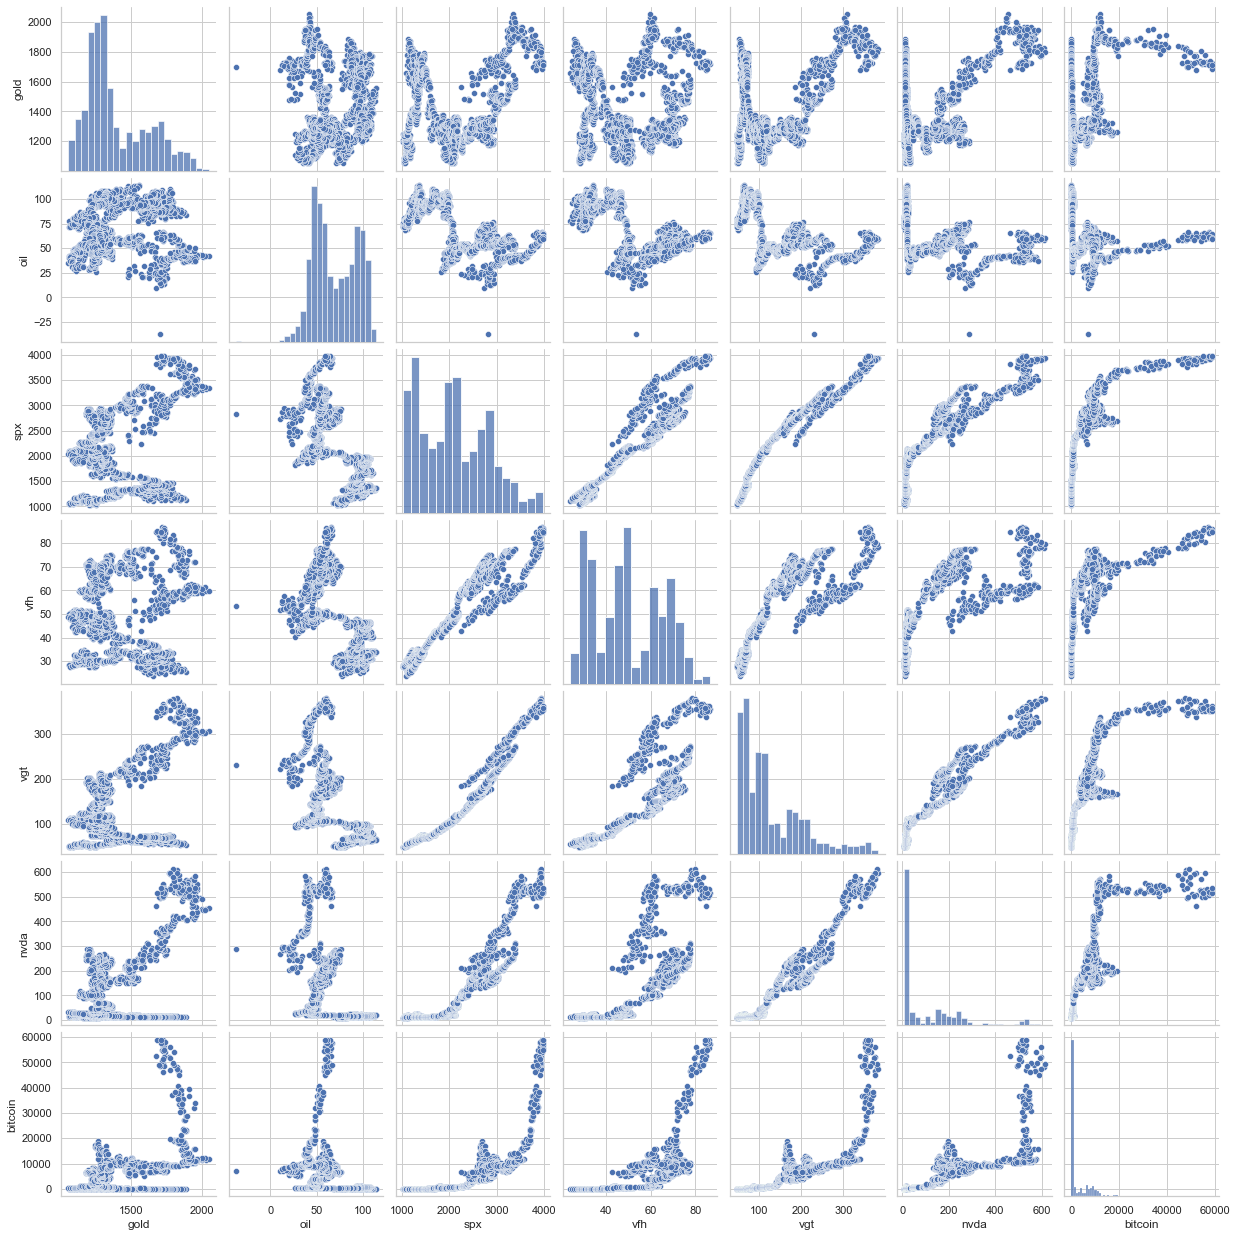

In [17]:
sns.pairplot(data = df_full)
plt.show()

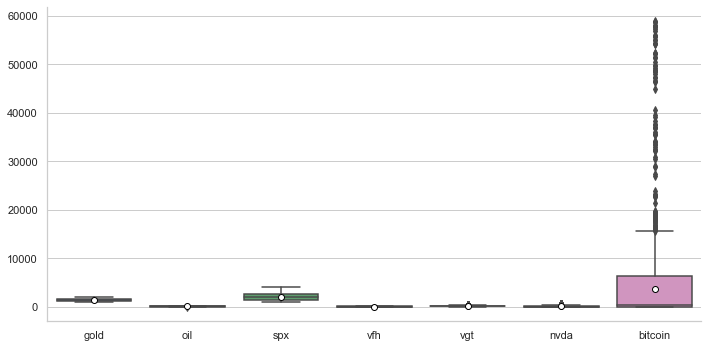

In [18]:
sns.catplot( data = df_full, kind='box', 
             showmeans=True, 
             meanprops={'marker': 'o', 'markerfacecolor': 'white',
                        'markeredgecolor':'black'},
             aspect=2 )

plt.show()

In [19]:
# log transformation 
df_full['bitcoin'] = np.log(df_full['bitcoin'])
df_full['nvda'] = np.log(df_full['nvda'])
df_full.head()

gold        oil      spx        vfh        vgt      nvda  \
date                                                                          
2009-11-02  1053.400024  78.129997  1042.88  28.270000  49.459999  2.490723   
2009-11-03  1084.300049  79.599998  1045.41  28.379999  49.450001  2.485740   
2009-11-04  1086.699951  80.400002  1046.50  28.030001  49.770000  2.483239   
2009-11-05  1088.699951  79.620003  1066.63  28.660000  50.930000  2.507157   
2009-11-06  1095.099976  77.430000  1069.30  28.559999  51.020000  2.577182   

             bitcoin  
date                  
2009-11-02 -6.679823  
2009-11-03 -6.666379  
2009-11-04 -6.640786  
2009-11-05 -6.640786  
2009-11-06 -6.656219

In [20]:
# create the standardized features
Xstan = StandardScaler().fit_transform(df_full)

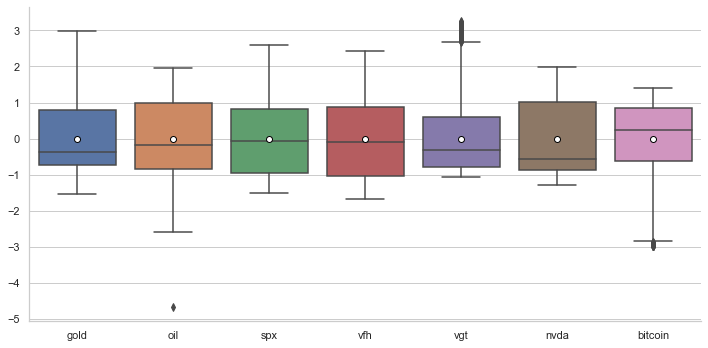

In [21]:
sns.catplot( data = pd.DataFrame(Xstan, columns=df_full.columns.to_list()), 
             kind='box', 
             showmeans=True, 
             meanprops={'marker': 'o', 'markerfacecolor': 'white',
                        'markeredgecolor':'black'},
             aspect=2 )

plt.show()

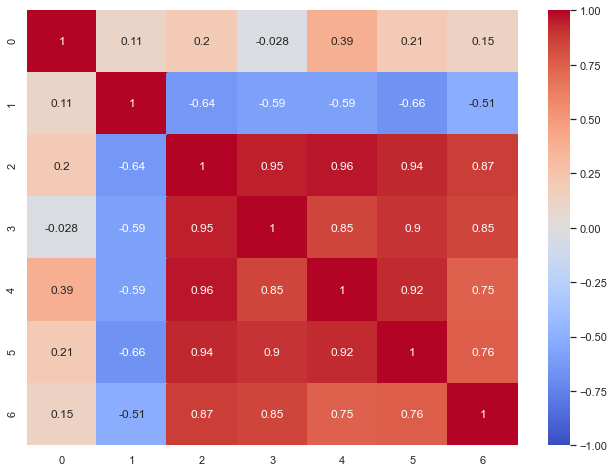

In [22]:
fig, ax = plt.subplots(figsize=(11,8))

sns.heatmap( data=pd.DataFrame(Xstan).corr(), vmin=-1, vmax=1, center=0, cmap='coolwarm', annot=True)
plt.show()

#### 2.3.2 Algorithms

### (1) K-means

_Find the optimal number of clusters._

In [23]:
Xarray = df_full.to_numpy()
tots_within = []

K = range(1, 16)

for k in K:
    km = KMeans(n_clusters=k, random_state=202, n_init=25, max_iter=500).fit(Xarray)
    tots_within.append(km.inertia_)

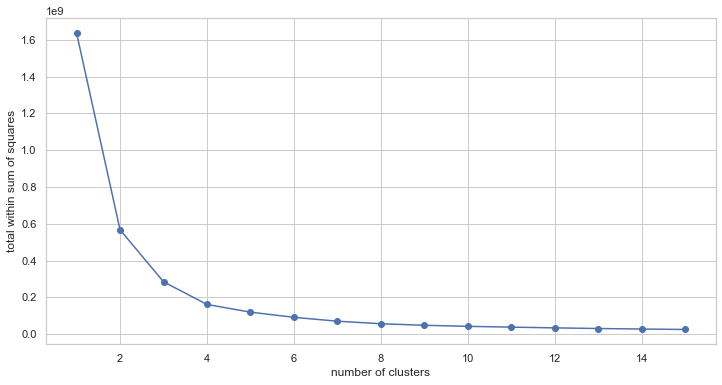

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(K, tots_within, 'bo-')
ax.set_xlabel('number of clusters')
ax.set_ylabel('total within sum of squares')
plt.show()

_Plot the optimal values._

In [25]:
df_full_vars = df_full.columns

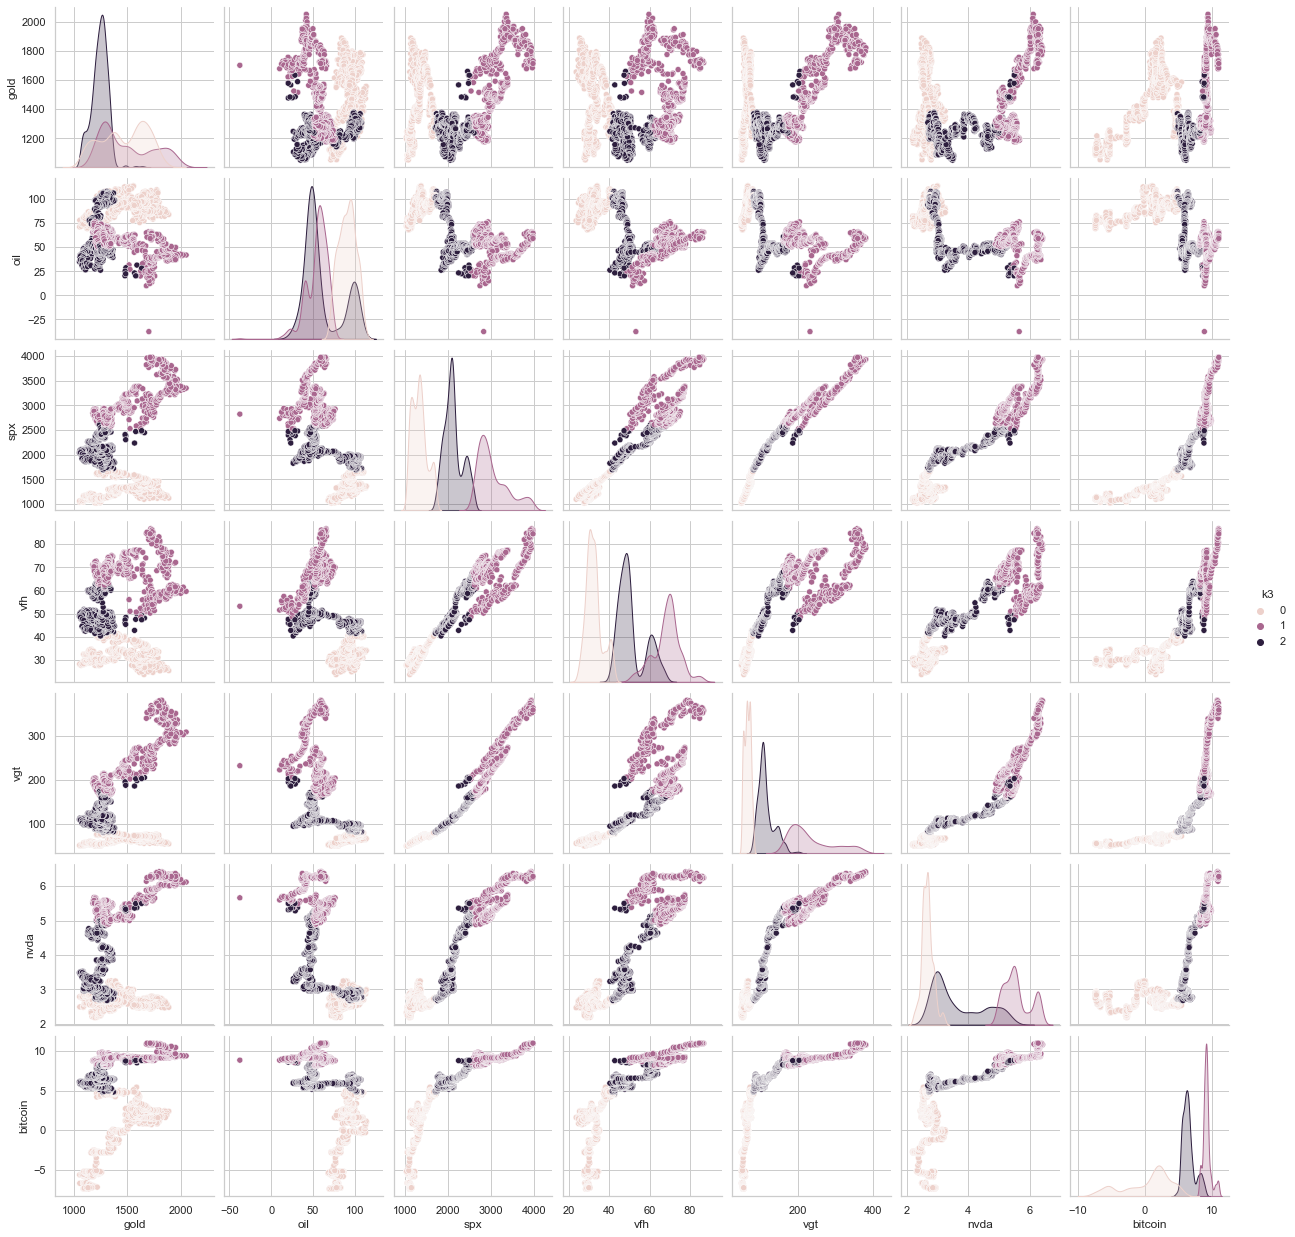

In [26]:
final_k = 3
mod_km = KMeans(n_clusters=final_k, random_state=202, n_init=25, max_iter=500).fit(Xarray)
prob_k3 = mod_km.fit_predict(Xarray) 
df_full['k3'] = prob_k3
sns.pairplot(data=df_full, vars=df_full_vars, hue='k3')
plt.show()

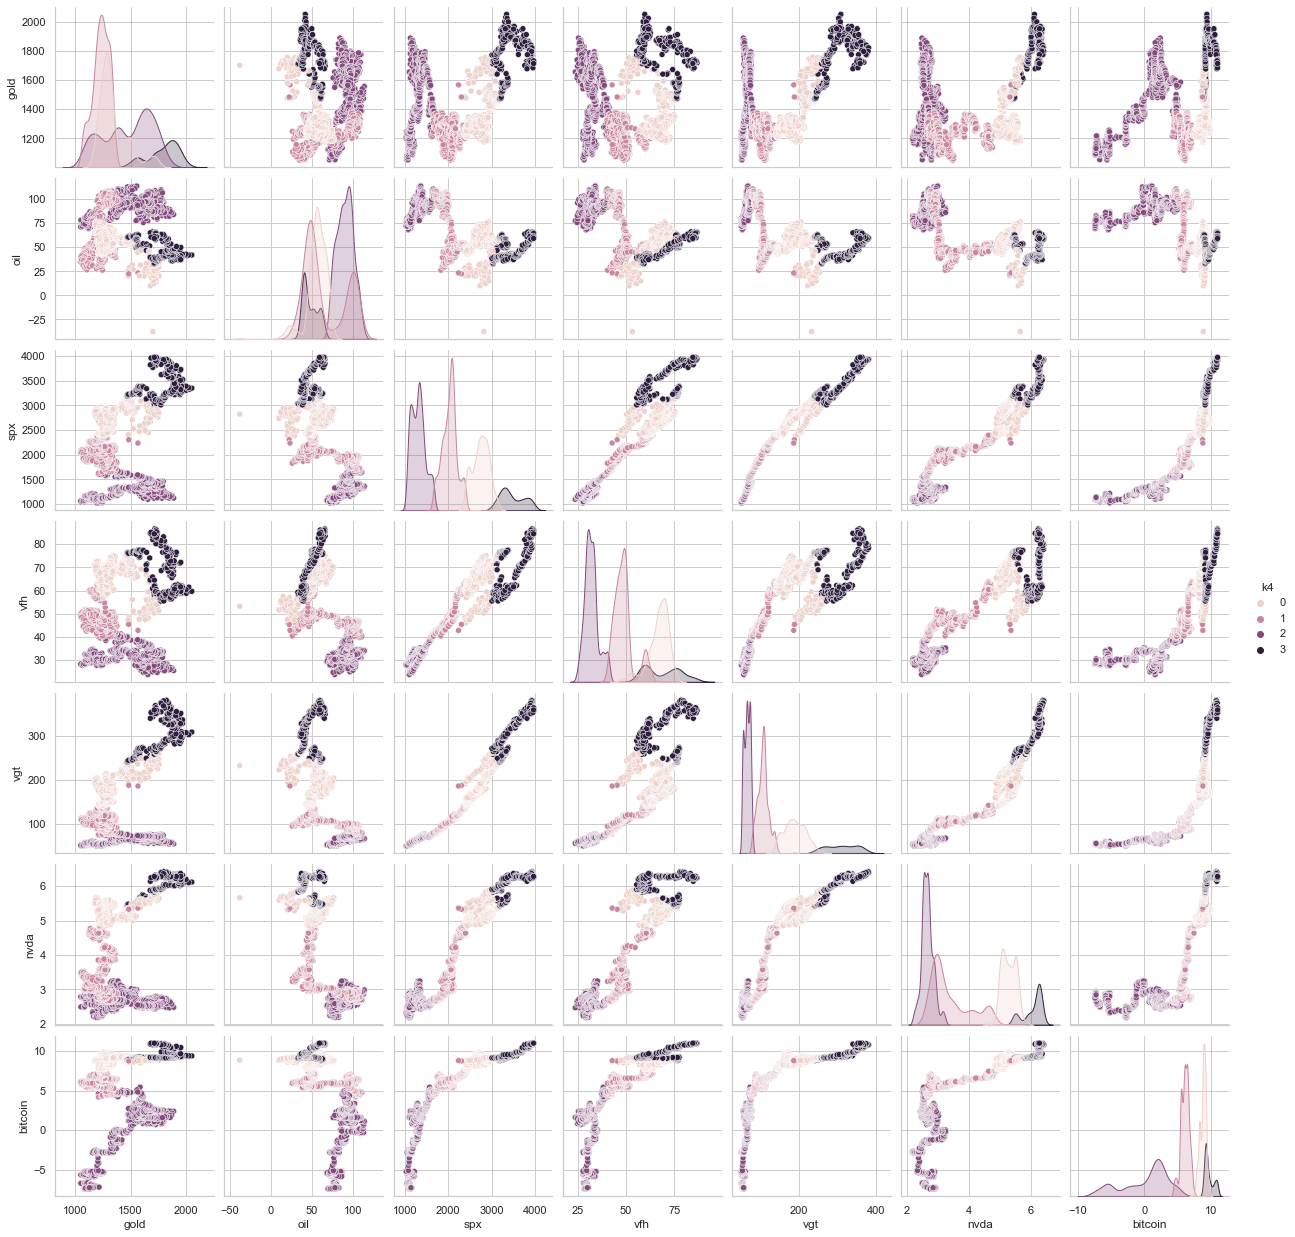

In [27]:
final_k = 4
mod_km = KMeans(n_clusters=final_k, random_state=202, n_init=25, max_iter=500).fit(Xarray)
prob_k4 = mod_km.fit_predict(Xarray) 
df_full['k4'] = prob_k4
sns.pairplot(data=df_full, vars=df_full_vars, hue='k4')
plt.show()

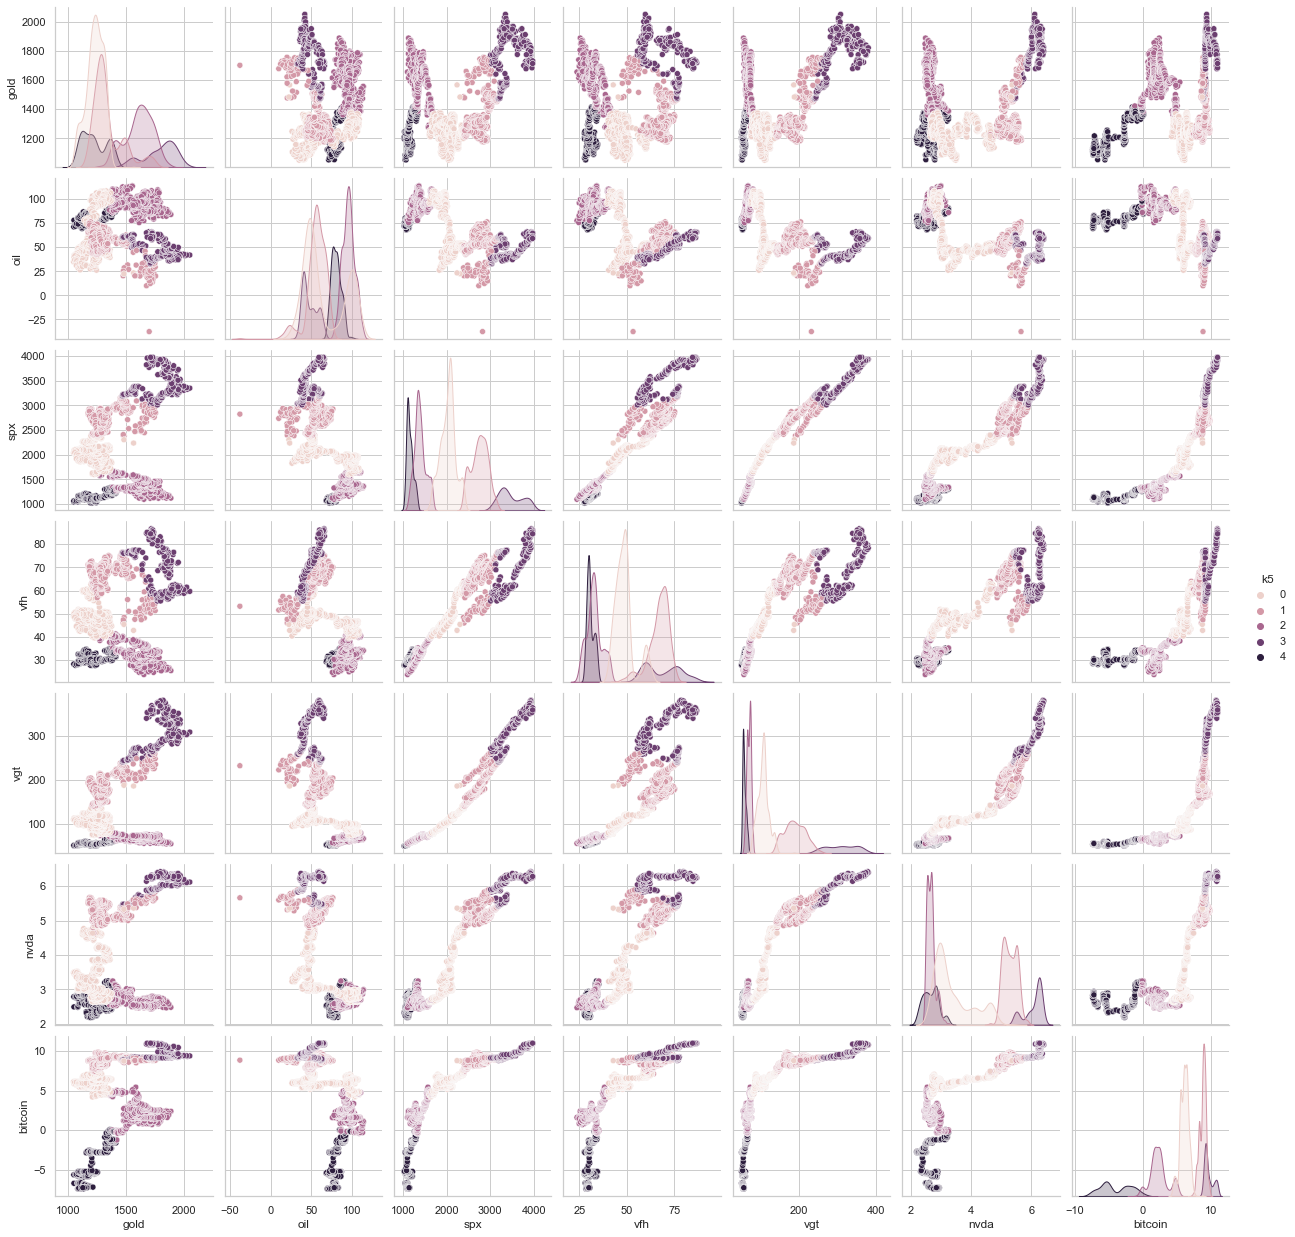

In [28]:
final_k = 5
mod_km = KMeans(n_clusters=final_k, random_state=202, n_init=25, max_iter=500).fit(Xarray)
prob_k5 = mod_km.fit_predict(Xarray) 
df_full['k5'] = prob_k5
sns.pairplot(data=df_full, vars=df_full_vars, hue='k5')
plt.show()

### (2) K-Means with Differencing
Detrending the series to avoid the autocorrelation.

In [29]:
# get the data
df_full_diff = pd.DataFrame(Xstan, columns=df_full_orig.columns)
df_full_diff.index = df_full_orig.index
df_full_diff.head()

gold       oil       spx       vfh       vgt      nvda  \
date                                                                     
2009-11-02 -1.525219  0.384828 -1.466841 -1.384556 -1.064539 -1.062736   
2009-11-03 -1.385494  0.449006 -1.463331 -1.377382 -1.064670 -1.066595   
2009-11-04 -1.374642  0.483933 -1.461819 -1.400208 -1.060490 -1.068531   
2009-11-05 -1.365598  0.449879 -1.433893 -1.359122 -1.045339 -1.050011   
2009-11-06 -1.336658  0.354268 -1.430189 -1.365643 -1.044164 -0.995793   

             bitcoin  
date                  
2009-11-02 -2.802517  
2009-11-03 -2.799322  
2009-11-04 -2.793241  
2009-11-05 -2.793241  
2009-11-06 -2.796908

In [30]:
# detrend the data
df_full_diff['bitcoin'] = sm.tsa.statespace.tools.diff(
    df_full_orig['bitcoin'], 
    k_diff=1, 
    k_seasonal_diff=None, 
    seasonal_periods=1)

df_full_diff['gold'] = sm.tsa.statespace.tools.diff(
    df_full_orig['gold'], 
    k_diff=1, 
    k_seasonal_diff=None, 
    seasonal_periods=1)

df_full_diff['oil'] = sm.tsa.statespace.tools.diff(
    df_full_orig['oil'], 
    k_diff=1, 
    k_seasonal_diff=None, 
    seasonal_periods=1)

df_full_diff['vfh'] = sm.tsa.statespace.tools.diff(
    df_full_orig['vfh'], 
    k_diff=1, 
    k_seasonal_diff=None, 
    seasonal_periods=1)

df_full_diff['vgt'] = sm.tsa.statespace.tools.diff(
    df_full_orig['vgt'], 
    k_diff=1, 
    k_seasonal_diff=None, 
    seasonal_periods=1)

df_full_diff['nvda'] = sm.tsa.statespace.tools.diff(
    df_full_orig['nvda'], 
    k_diff=1, 
    k_seasonal_diff=None, 
    seasonal_periods=1)

df_full_diff = df_full_diff.dropna() 
df_full_diff.head()

gold       oil       spx       vfh       vgt  nvda   bitcoin
date                                                                         
2009-11-03  30.900025  1.470001 -1.463331  0.109999 -0.009998 -0.06  0.000017
2009-11-04   2.399902  0.800004 -1.461819 -0.349998  0.319999 -0.03  0.000033
2009-11-05   2.000000 -0.779999 -1.433893  0.629999  1.160000  0.29  0.000000
2009-11-06   6.400025 -2.190003 -1.430189 -0.100001  0.090000  0.89 -0.000020
2009-11-09   5.700073  2.000000 -1.397199  0.970002  1.060002  0.30 -0.000026

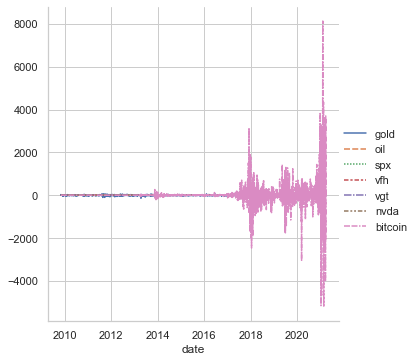

In [31]:
# check values
sns.relplot(data=df_full_diff, kind='line')
plt.show()

In [32]:
# standardize the columns
df_full_diff = StandardScaler().fit_transform(df_full_diff)

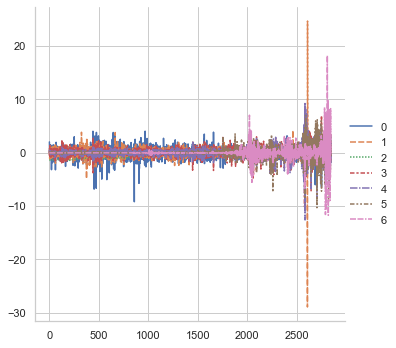

In [33]:
# check values
sns.relplot(data=df_full_diff, kind='line')
plt.show()

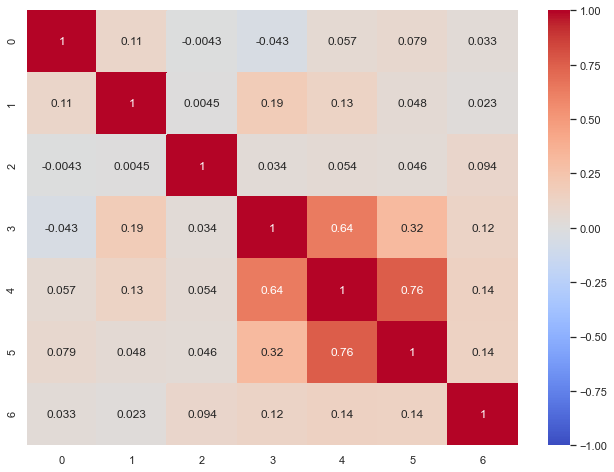

In [34]:
# check correlation
fig, ax = plt.subplots(figsize=(11,8))

sns.heatmap( data=pd.DataFrame(df_full_diff).corr(), vmin=-1, vmax=1, center=0, cmap='coolwarm', annot=True)
plt.show()

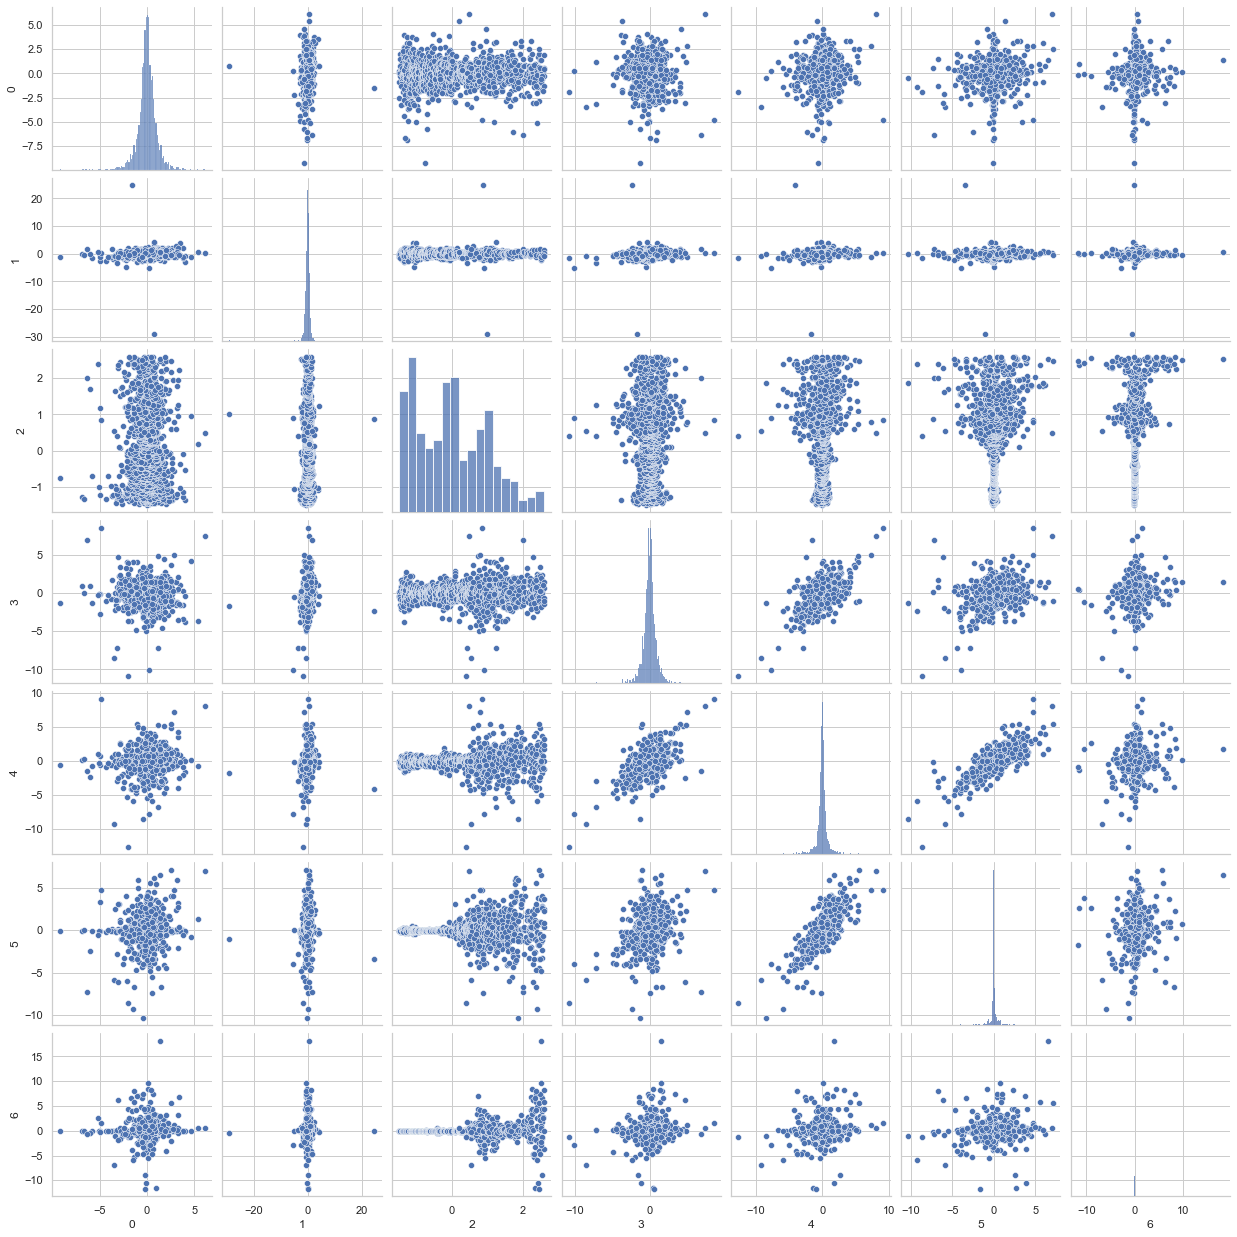

In [35]:
# plot distributions
sns.pairplot(data=pd.DataFrame(df_full_diff))
plt.show()

In [36]:
# train the models
Xarray_diff = df_full_diff
tots_within_diff = []

K = range(1, 30)

for k in K:
    km = KMeans(n_clusters=k, random_state=202, n_init=25, max_iter=500).fit(Xarray_diff)
    tots_within_diff.append(km.inertia_)

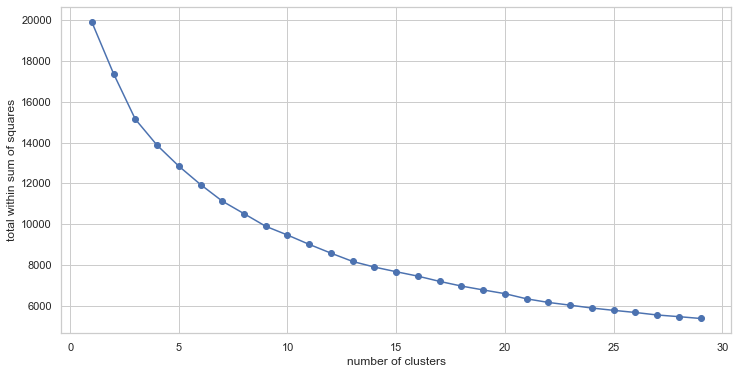

In [37]:
# plot the results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(K, tots_within_diff, 'bo-')
ax.set_xlabel('number of clusters')
ax.set_ylabel('total within sum of squares')
plt.show()

_Plot the optimal values. Although hard to figure out the number in this case._

In [39]:
df_full_diff = pd.DataFrame(df_full_diff)
df_full_diff_vars = df_full_diff.columns

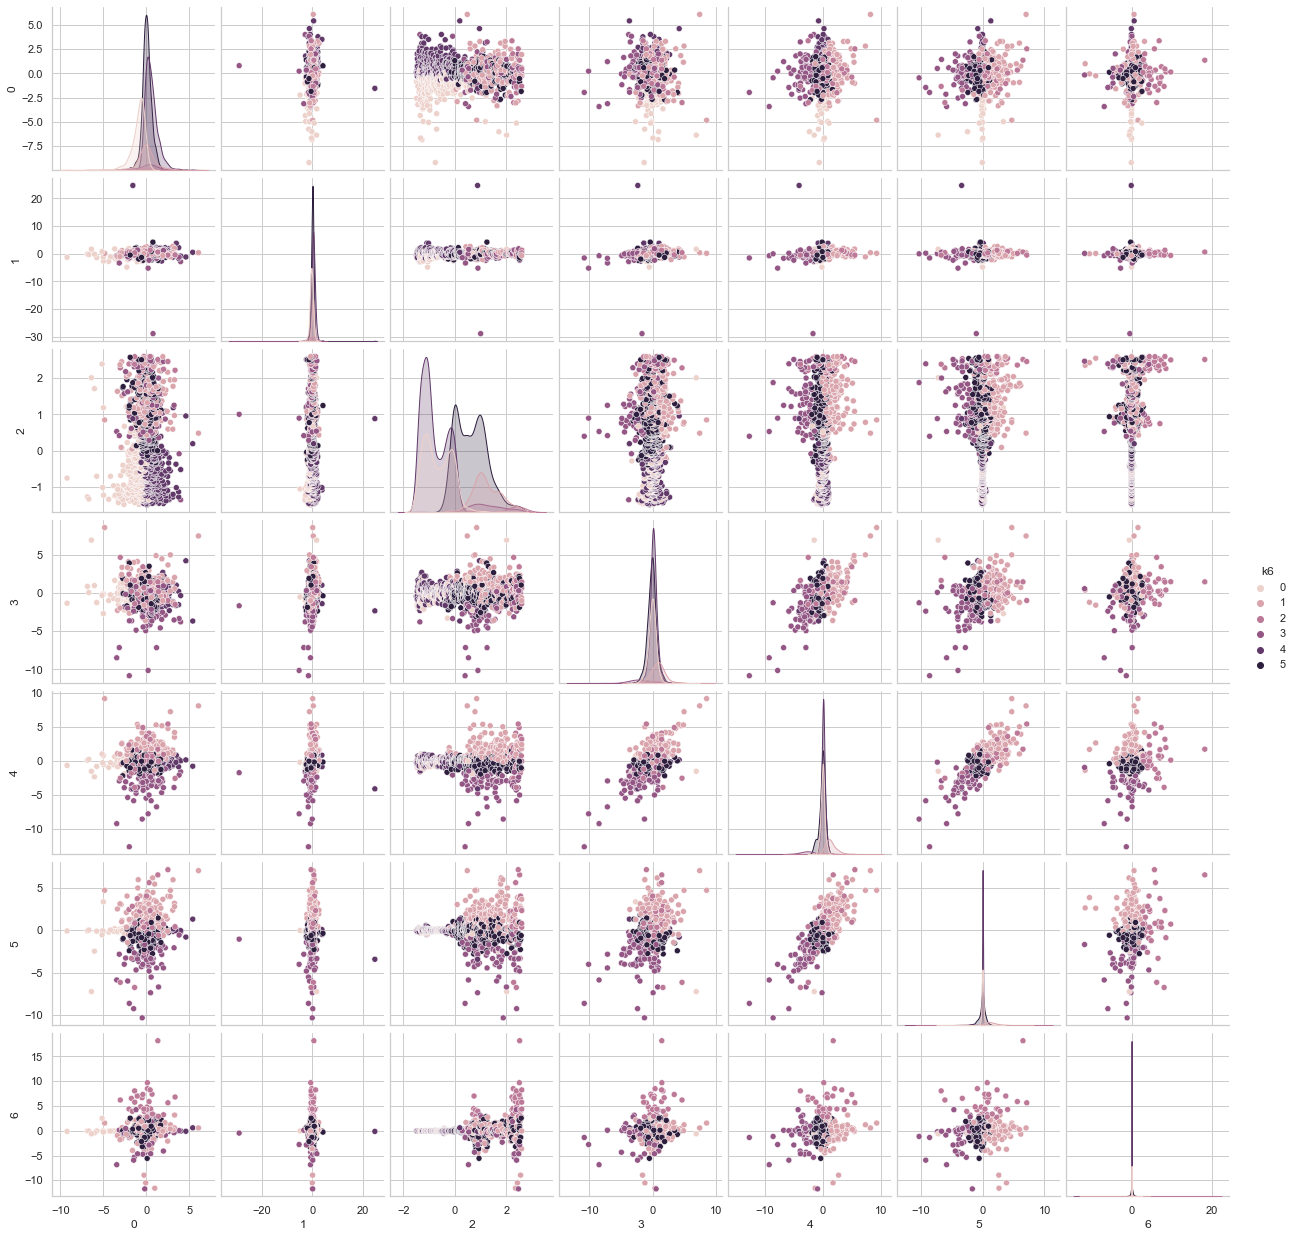

In [42]:
final_k = 6
mod_km = KMeans(n_clusters=final_k, random_state=202, n_init=25, max_iter=500).fit(Xarray_diff)
prob_k6 = mod_km.fit_predict(Xarray_diff) 
df_full_diff['k6'] = prob_k6
sns.pairplot(data=df_full_diff, vars=df_full_diff_vars, hue='k6')
plt.show()